# Regression using Fully-Connected Neural Network

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

## 数据集

In [5]:
def create_toy_data(f, sample_size, std=0.25, noise=True):
    x = np.linspace(0, 1, sample_size)
    if noise:
        y = f(x) + np.random.normal(scale=std, size=x.shape)
    else:
        y = f(x)
    return x, y

In [6]:
def f(x):
    return np.sin(2*np.pi*x)

In [7]:
x_train, y_train = create_toy_data(f,100)
x_valid, y_valid = create_toy_data(f,50)
x_exact, y_exact = create_toy_data(f, 100, noise=False)

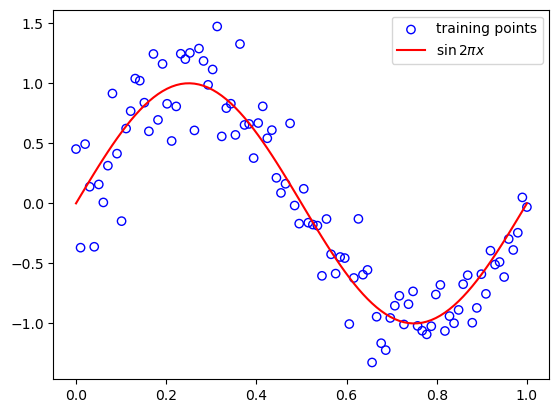

In [8]:
plt.scatter(x_train, y_train, facecolor='none', edgecolors='b',
           label='training points')
plt.plot(x_exact, y_exact, 'r-', label='$\sin 2\pi x$')
plt.legend()

In [9]:
class MyDataset(Dataset):
    def __init__(self, f, sample_size=100):
        x, y = create_toy_data(f, sample_size)
        self.x = torch.from_numpy(x).unsqueeze(dim=-1).float()
        self.y = torch.from_numpy(y).unsqueeze(dim=-1).float()
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        sample = {'x' : self.x[index], 'y': self.y[index]}
        return sample

In [10]:
my_dataset = MyDataset(f, 50)
dataloader = DataLoader(my_dataset, batch_size=5, shuffle=True, drop_last=True)

dataloader

In [11]:
for i, sample in enumerate(dataloader):
    print(f"{i}: {sample['x']},{sample['y']}")
    

0: tensor([[0.0000],
        [0.9184],
        [0.4286],
        [0.7755],
        [0.5102]]),tensor([[-0.1095],
        [-0.4222],
        [ 0.5016],
        [-0.9694],
        [-0.3138]])
1: tensor([[0.3878],
        [0.5306],
        [0.1224],
        [0.7551],
        [0.3469]]),tensor([[ 0.3838],
        [-0.2605],
        [ 0.3602],
        [-0.9262],
        [ 0.9196]])
2: tensor([[0.1837],
        [0.2041],
        [0.5918],
        [0.4694],
        [0.4898]]),tensor([[ 1.0067],
        [ 1.1743],
        [-0.3979],
        [ 0.0973],
        [ 0.1947]])
3: tensor([[0.8980],
        [0.2449],
        [0.8776],
        [0.9796],
        [0.2653]]),tensor([[-0.5852],
        [ 0.8172],
        [-0.5589],
        [-0.2347],
        [ 1.3551]])
4: tensor([[0.3265],
        [0.9592],
        [0.7143],
        [0.2245],
        [0.0612]]),tensor([[ 0.3816],
        [ 0.1616],
        [-1.1835],
        [ 0.9440],
        [ 0.4051]])
5: tensor([[0.6327],
        [0.6122],
        [0.

## 神经网络

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, layers=[1,10,10,10,1]):
        super().__init__()
        
        self.fcs = []
        for i in range(len(layers)-1):
            fc = nn.Linear(layers[i], layers[i+1])
            setattr(self, f'fc{i+1}', fc)
            self._init_weights(fc)
            self.fcs.append(fc)
            
    def _init_weights(self, layer):
        nn.init.xavier_normal_(layer.weight)
        nn.init.constant_(layer.bias, 0.01)
        
    def forward(self, x):
        for i in range(len(self.fcs)-1):
            x = self.fcs[i](x)
            x = torch.tanh(x)
            
        return self.fcs[-1](x)

In [14]:
model = SimpleNet()
print(model)

SimpleNet(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [15]:
x = torch.rand(10, 1)
x

tensor([[0.7342],
        [0.0511],
        [0.6787],
        [0.9912],
        [0.6912],
        [0.4980],
        [0.6867],
        [0.1966],
        [0.3985],
        [0.6317]])

In [16]:
y = model(x)
y.shape

torch.Size([10, 1])

## 训练

In [20]:
#准备数据

trainset = MyDataset(f, 100)
validset = MyDataset(f, 20)

trainloader = DataLoader(trainset, batch_size=20, shuffle=True)

#模型
layers = [1, 20, 20, 20, 1]
model = SimpleNet(layers)

#损失函数
criterion = nn.MSELoss()

#优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    
    train_loss = 0
    
    for i, sample in enumerate(trainloader):
        x, y = sample['x'], sample['y']
            
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()* x.shape[0]
        
    train_loss /= len(trainset)
    
    if epoch % 10 ==0:
        
        #验证集
        x, y = validset.x, validset.y
        y_pred = model(x)
        
        valid_loss = criterion(y_pred, y).item()
        
        print(f'Epoch {epoch:3d}:'+
             f'train loss: {train_loss}'+
             f'valid loss: {train_loss}')
        

Epoch   0:train loss: 0.4357879340648651valid loss: 0.4357879340648651
Epoch  10:train loss: 0.24322283864021302valid loss: 0.24322283864021302
Epoch  20:train loss: 0.22455428540706635valid loss: 0.22455428540706635
Epoch  30:train loss: 0.08801199123263359valid loss: 0.08801199123263359
Epoch  40:train loss: 0.07935157716274262valid loss: 0.07935157716274262
Epoch  50:train loss: 0.08430530950427055valid loss: 0.08430530950427055
Epoch  60:train loss: 0.06714621484279633valid loss: 0.06714621484279633
Epoch  70:train loss: 0.06657524034380913valid loss: 0.06657524034380913
Epoch  80:train loss: 0.07963154911994934valid loss: 0.07963154911994934
Epoch  90:train loss: 0.0743848815560341valid loss: 0.0743848815560341
Epoch 100:train loss: 0.06743973568081855valid loss: 0.06743973568081855
Epoch 110:train loss: 0.06357867494225503valid loss: 0.06357867494225503
Epoch 120:train loss: 0.0713685043156147valid loss: 0.0713685043156147
Epoch 130:train loss: 0.07071969732642173valid loss: 0.07